In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 3 May 2023
# Description:
#     this script compares methods of calculate the OHC and surface heat flux integrated over the continental shelf
#     - update to xarray open_mfdataset from open_dataset brought new functions more efficient to calculate model layer thickness (dz)
# and ocean heat content tendencies (rho0*Cp*dT/dt). 

# - update 23/8/23: re-ran waom10 saving daily outputs in 5-days files.
# I suspect that the monthly files with unequal number of time-fields 
# causes differences in the dt for his and avg files, reflected in the 
# residue for the Antarctic shelf seas heat budget.

In [2]:
# read nc output from WAOM 10km run

import xarray as xr
# import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')

In [3]:
client = Client(threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
print(client)

<Client: 'tcp://127.0.0.1:45107' processes=28 threads=28>


2024-06-24 14:47:32,951 - distributed.scheduler - ERROR - Couldn't gather keys: {('concatenate-aa3def0adbf787bfccc84947b8d2a27f', 45, 0, 1, 0): 'memory', ('concatenate-aa3def0adbf787bfccc84947b8d2a27f', 26, 0, 1, 0): 'memory', ('concatenate-aa3def0adbf787bfccc84947b8d2a27f', 51, 0, 1, 0): 'memory', ('concatenate-aa3def0adbf787bfccc84947b8d2a27f', 50, 0, 1, 0): 'memory', ('concatenate-aa3def0adbf787bfccc84947b8d2a27f', 70, 0, 1, 0): 'memory', ('concatenate-aa3def0adbf787bfccc84947b8d2a27f', 28, 0, 0, 0): 'memory', ('concatenate-aa3def0adbf787bfccc84947b8d2a27f', 0, 0, 1, 0): 'memory', ('concatenate-aa3def0adbf787bfccc84947b8d2a27f', 3, 0, 0, 0): 'memory', ('concatenate-aa3def0adbf787bfccc84947b8d2a27f', 25, 0, 1, 0): 'memory', ('concatenate-aa3def0adbf787bfccc84947b8d2a27f', 53, 0, 0, 0): 'memory', ('concatenate-aa3def0adbf787bfccc84947b8d2a27f', 46, 0, 0, 0): 'memory', ('concatenate-aa3def0adbf787bfccc84947b8d2a27f', 5, 0, 1, 0): 'memory', ('concatenate-aa3def0adbf787bfccc84947b8d2a27f

In [4]:
fig_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/'

In [5]:
%%time

# using xr.open_mfdataset

vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]

ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False) # , concat_dim="ocean_time"

#- preserving 5-days avgs
zeta = ds.variables["zeta"] 
temp = ds.variables["temp"] 
salt = ds.variables["salt"]
shflux = ds.variables["shflux"] 
ssflux = ds.variables["ssflux"]
m = ds.variables["m"]
HvomT = ds.variables["Hvom_temp"]       ## !!! Huon_temp/Hvom_temp were not saved in the original run
HuonT = ds.variables["Huon_temp"]       ## now it's running here: /scratch/gi0/fbd581/waom4extend_shflim_S_0.25Q/output_yr10_diag
Hvom = ds.variables["Hvom"] 
Huon = ds.variables["Huon"] 
time_avg = ds.variables["ocean_time"] 
ice_draft = ds.variables["zice"]

mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))

print("Vtransform=2")
#  New formulation (Vtransform(ng) = 2):
#
#         z_w(x,y,s,t) = zeta(x,y,t) + [zeta(x,y,t)+ h(x,y)] * Zo_w
#                 Zo_w = [hc * s(k) + C(k) * h(x,y)] / [hc + h(x,y)]
hwater = ds.h- abs(ds.zice) # replace ds.h for hwater below
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
z_rho = ds.zeta + (ds.zeta + hwater) * Zo_rho 

Zo_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
z_w = ds.zeta + (ds.zeta + hwater) * Zo_w 

dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
lat_u = dg.variables["lat_u"]
lon_u = dg.variables["lon_u"]
lat_v = dg.variables["lat_v"]
lon_v = dg.variables["lon_v"]
pm = dg.variables["pm"]
pn = dg.variables["pn"]
h = dg.variables["h"]
zice = dg.variables["zice"]

ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

ds.close()
dg.close()

# calculate surface sigma_theta (potential density)
sigma_t_sfc = gsw.rho(salt[:,-1,:,:],temp[:,-1,:,:],0) - 1000
area=np.divide(1,pm*pn)

Vtransform=2
CPU times: user 30.1 s, sys: 7.95 s, total: 38 s
Wall time: 1min 16s


In [6]:
# load horizontal diffusion of heat calculated online:
	# float temp_hdiff(ocean_time, s_rho, eta_rho, xi_rho) ;

ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_dia_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False)
temp_hdiff = ds.variables["temp_hdiff"] 
temp_vdiff = ds.variables["temp_vdiff"] 
temp_sdiff = ds.variables["temp_sdiff"]  #"potential temperature, horizontal S-diffusion rotated tensor term"
temp_hadv = ds.variables["temp_hadv"] 
temp_vadv = ds.variables["temp_vadv"] 
ds.close()

In [7]:
%%time
# method 2 to calculate Dz:
# z_w=z_w.chunks(chunks={'eta_rho': '200MB'}) # couldn't change chunks.

Z_w = z_w.transpose('ocean_time','s_w','eta_rho','xi_rho')
print(z_w.shape, Z_w.shape)
dz = np.diff(Z_w,axis=1)


(365, 560, 630, 32) (365, 32, 560, 630)
CPU times: user 29.1 s, sys: 56.9 s, total: 1min 26s
Wall time: 1min 23s


In [8]:
# convert dz to xarray:
months=np.arange(0,365)*(1/30.41667)
# save to netcdf file:
coordinatesC=dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)), eta_rho=(['eta_rho'], np.arange(0,560)), xi_rho=(['xi_rho'], np.arange(0,630)))

dz_xr = xr.DataArray(dz, coords = coordinatesC, dims = ['ocean_time','s_rho','eta_rho','xi_rho'])


In [9]:
temp_vadv.load()
temp_hadv.load()

<xarray.Variable (ocean_time: 365, s_rho: 31, eta_rho: 560, xi_rho: 630)> Size: 16GB
array([[[[ 1.67195776e-06,  1.67195776e-06, -1.55184694e-06, ...,
          -5.58577938e-07, -3.37030087e-07, -3.37030087e-07],
         [ 1.67195776e-06,  1.67195776e-06, -1.55184694e-06, ...,
          -5.58577938e-07, -3.37030087e-07, -3.37030087e-07],
         [ 5.72446106e-06,  5.72446106e-06,  6.07138702e-07, ...,
          -3.50623537e-07, -4.94417066e-07, -4.94417066e-07],
         ...,
         [-1.10337260e-06, -1.10337260e-06, -1.98637213e-06, ...,
          -1.53627491e-06,  3.07586720e-06,  3.07586720e-06],
         [ 5.40510018e-06,  5.40510018e-06, -4.85127293e-06, ...,
           3.81703330e-06, -3.25185852e-06, -3.25185852e-06],
         [ 5.40510018e-06,  5.40510018e-06, -4.85127293e-06, ...,
           3.81703330e-06, -3.25185852e-06, -3.25185852e-06]],

        [[ 2.82995120e-06,  2.82995120e-06, -2.41523503e-06, ...,
          -5.15553950e-07, -2.73867641e-07, -2.73867641e-07],
         [ 2.82995120e-06,  2.82995120e-06, -2.41523503e-06, ...,
          -5.15553950e-07, -2.73867641e-07, -2.73867641e-07],
         [ 4.88152500e-06,  4.88152500e-06, -1.31782642e-07, ...,
          -3.13384078e-07, -3.25401231e-07, -3.25401231e-07],
...
          -3.26827139e-05, -8.35643459e-06, -8.35643459e-06],
         [ 4.08480417e-07,  4.08480417e-07, -3.17359991e-06, ...,
           3.71903770e-05,  6.07571783e-05,  6.07571783e-05],
         [ 4.08480417e-07,  4.08480417e-07, -3.17359991e-06, ...,
           3.71903770e-05,  6.07571783e-05,  6.07571783e-05]],

        [[ 4.63790493e-05,  4.63790493e-05,  6.02087748e-05, ...,
           3.34388496e-05,  3.46523084e-05,  3.46523084e-05],
         [ 4.63790493e-05,  4.63790493e-05,  6.02087748e-05, ...,
           3.34388496e-05,  3.46523084e-05,  3.46523084e-05],
         [-2.61633177e-05, -2.61633177e-05, -8.93851848e-06, ...,
           1.46763578e-05,  2.08350975e-05,  2.08350975e-05],
         ...,
         [-4.42021928e-06, -4.42021928e-06, -1.29115560e-05, ...,
          -6.53078496e-06,  1.41635974e-05,  1.41635974e-05],
         [ 1.12959879e-05,  1.12959879e-05,  2.83039644e-05, ...,
           4.32215566e-05,  1.01863363e-04,  1.01863363e-04],
         [ 1.12959879e-05,  1.12959879e-05,  2.83039644e-05, ...,
           4.32215566e-05,  1.01863363e-04,  1.01863363e-04]]]],
      dtype=float32)
Attributes:
    long_name:  potential temperature, horizontal advection term
    units:      Celsius second-1
    time:       ocean_time
    field:      temp_hadv, scalar, series

In [10]:
temp_vadv_dz = temp_vadv*dz_xr
temp_hadv_dz = temp_hadv*dz_xr

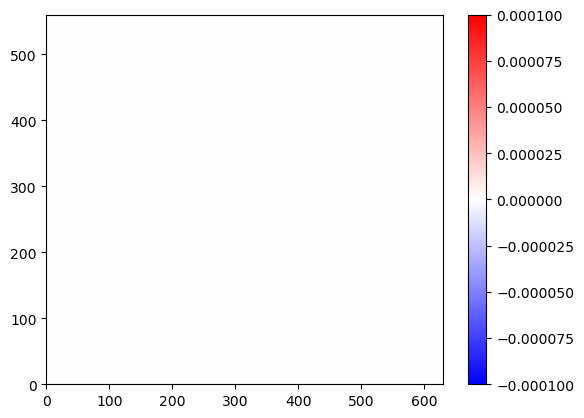

In [12]:
plt.pcolormesh(temp_vadv_dz.sum('s_rho').mean('ocean_time'), cmap='bwr', vmin=-0.0001, vmax=0.0001)
plt.colorbar()

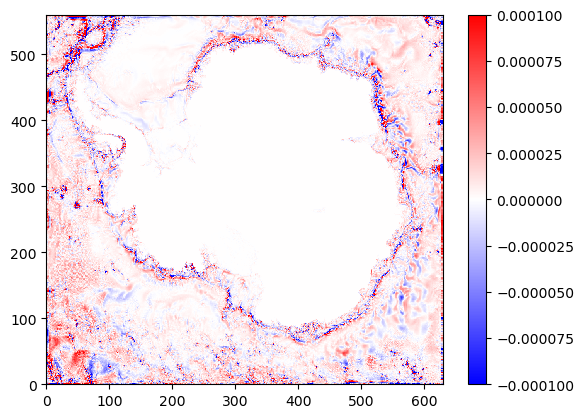

In [13]:
plt.pcolor(temp_hadv_dz.sum('s_rho').mean('ocean_time'), cmap='bwr', vmin=-0.0001, vmax=0.0001)
plt.colorbar()

In [14]:
files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'


In [85]:
contour_masked_above = np.load(files_path + 'WAOM10_contour_masked_above_1500m_v3', allow_pickle=True)
contour_masked_above_CF = np.load(files_path + 'WAOM10_contour_masked_above_CF_v3', allow_pickle=True)


### continue original script:

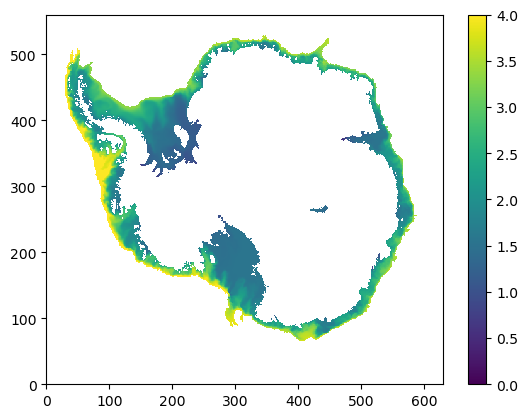

In [86]:
Tf = -3.55
plt.pcolormesh(ma.masked_where(contour_masked_above == -1000, temp.isel(s_rho=0).mean('ocean_time')-Tf), vmin=0, vmax=4)
plt.colorbar()

In [23]:
%%time

ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_his_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, decode_times=False) #, chuncks="auto", concat_dim="ocean_time"

#- preserving 5-days avgs
temp_snap = ds.variables["temp"] ##+273.15 (changing to Kelvin didn't change any results)
time_snap = ds.variables["ocean_time"]
ds.close()


CPU times: user 22.1 s, sys: 4.49 s, total: 26.6 s
Wall time: 46.4 s


In [24]:
%%time

# calculate dT/dt by differentiating temp_snap:
temp_Rate = np.empty(temp_snap.shape)
dT = np.empty(temp_snap.shape)

# needs the initial conditions:
ds = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_11-20yr/ocean_rst.nc')
temp_ini = ds.variables["temp"].isel(ocean_time=8, two=0) ##+273.15 (changing to Kelvin didn't change any results) # 5-days mean
time_ini = ds.variables["ocean_time"].isel(ocean_time=8)
ds.close()

    
tlen = len(temp[:,0,0,0])

CPU times: user 176 ms, sys: 88.3 ms, total: 264 ms
Wall time: 553 ms


In [25]:
%%time

# transform to DataArray
temp_snap = xr.DataArray(temp_snap)
temp_ini = xr.DataArray(temp_ini)

# - append temp_ini to first time index in temp_snap and then do diff
temp_snap = xr.concat([temp_ini,temp_snap], 'ocean_time')
dT = temp_snap.diff('ocean_time')
print(dT.shape)

# 
# dt = 5*86400 # 5-days in seconds
dt = 86400 # 1day
temp_Rate = np.divide(dT, dt)
temp_Rate = xr.DataArray(temp_Rate)
# temp_Rate=temp_Rate.rename({'dim_0':'ocean_time','dim_1':'s_rho','dim_2':'eta_rho','dim_3':'xi_rho'})

print(dT.shape)

temp_Rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')

print(temp_Rate.shape)

(31, 560, 630, 365)
(31, 560, 630, 365)
(365, 31, 560, 630)
CPU times: user 206 ms, sys: 174 ms, total: 380 ms
Wall time: 475 ms


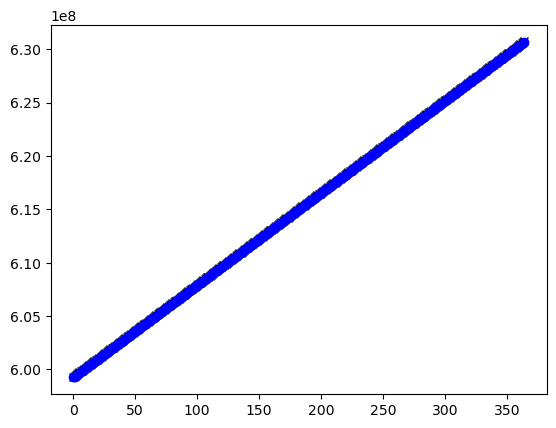

In [26]:
# check time stamps across his/avg variables to make sure they match:


# # print('1.', time_snap)
# print('2.', 2007+(time_snap[0]/86400/365))
# print('3.', time_ini)
# time_ini_datenum = (np.datetime64('2025-12-27')-np.datetime64('2007-01-01'))
# print('4.', time_ini_datenum/365, ', NOT days, years!')
# print('5.', (599616000-599184000)/86400) # 5-days!

# time_snap_np = time_snap.values
# time_ini_np = time_ini.values
# print(time_ini, time_snap_np.shape)
# time_snap2 = np.concatenate((time_ini_np,time_snap_np), axis=0)
# print(time_snap2.shape)

# # transform to DataArray
# time_snap = xr.DataArray(time_snap)
# time_ini = xr.DataArray(time_ini)

# print(time_snap.shape, time_ini.shape)

# # - append temp_ini to first time index in temp_snap and then do diff
# time_snap2 = xr.concat([time_ini,time_snap], 'ocean_time')

# print(time_snap2.shape, time_avg.shape)

plt.plot(np.arange(0,365),time_snap,'xk')
plt.plot(np.arange(0,365),time_avg,'ob')
# plt.plot(np.arange(0,365),time_snap2,'.r')
# plt.xlim(0,5)


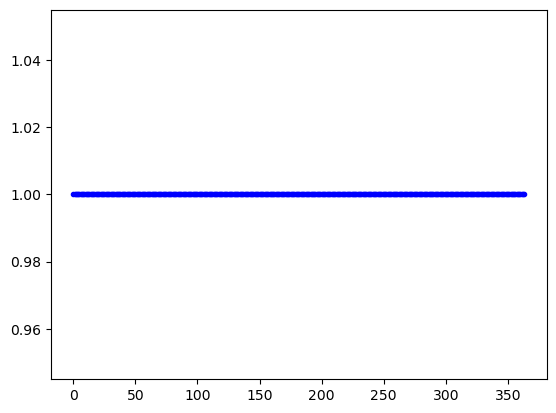

In [27]:
# calculate dt for avg/his timestamps:

dt_avg = np.diff(time_avg)
dt_snap = np.diff(time_snap)

plt.plot(np.arange(0,364),dt_avg/86400,'.b')

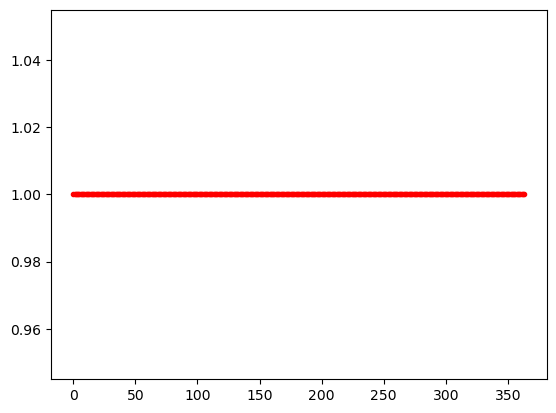

In [28]:
plt.plot(np.arange(0,364),dt_snap/86400,'.r')


In [100]:
# determine constants:
# rho0 = 1025 # kg. m-3
# Cp = 3989.245 # J.kg-1.degC-1
# Tf = -1.95 # degC
# use same value as ACCESS-OM2
rho0=1035
Cp=3992.1
# Tf = -1.95 # degC
Tf =  -3.534879684448242

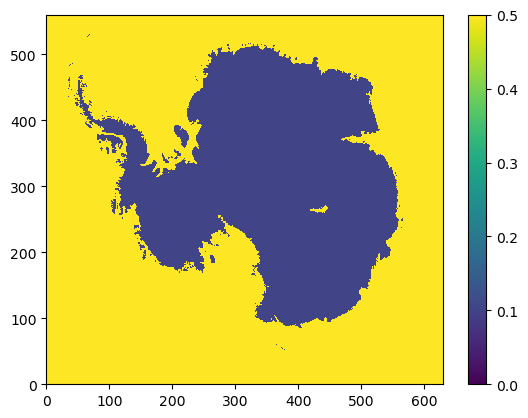

In [32]:
plt.pcolormesh(h-abs(zice), vmin=0, vmax=0.5)
plt.colorbar()

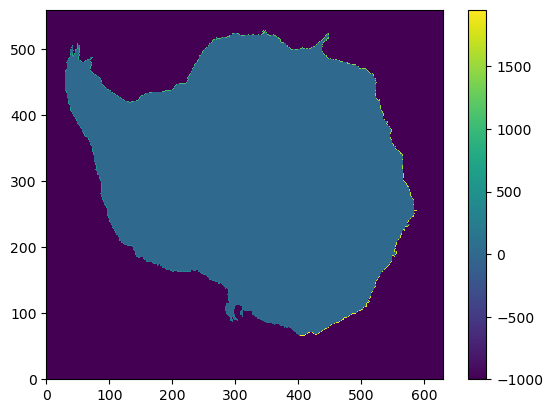

In [87]:
plt.pcolormesh(contour_masked_above)#, vmin=0, vmax=1)
plt.colorbar()

In [88]:
# Define conditions to mask out (1) off the shelf, (2) land (see plots above)
condition1 = contour_masked_above == -1000
condition2 = (zice+h) <= 1

# Combine conditions with logical OR
combined_condition = condition1 | condition2


In [89]:
temp_rate.load()
temp_hadv.load()
temp_vadv.load()
temp_hdiff.load()
temp_vdiff.load()
temp_sdiff.load()

2024-06-24 15:55:52,474 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:38133
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/comm/tcp.py", line 546, in connect
    stream = await self.client.connect(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/tornado/tcpclient.py", line 279, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/asyncio/tasks.py", line 456, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/minic

<xarray.Variable (ocean_time: 365, s_rho: 31, eta_rho: 560, xi_rho: 630)> Size: 16GB
array([[[[-2.28925199e-08, -2.28925199e-08, -5.51353718e-09, ...,
          -4.62630023e-09, -6.55865984e-09, -6.55865984e-09],
         [-2.28925199e-08, -2.28925199e-08, -5.51353718e-09, ...,
          -4.62630023e-09, -6.55865984e-09, -6.55865984e-09],
         [-2.32045338e-07, -2.32045338e-07,  9.53852535e-08, ...,
          -9.05510333e-09, -1.16267884e-08, -1.16267884e-08],
         ...,
         [ 1.24748254e-07,  1.24748254e-07,  3.83622201e-09, ...,
           2.00319885e-08,  3.79742922e-08,  3.79742922e-08],
         [ 2.20846431e-07,  2.20846431e-07,  8.54360316e-09, ...,
           5.94508762e-08,  8.08420211e-08,  8.08420211e-08],
         [ 2.20846431e-07,  2.20846431e-07,  8.54360316e-09, ...,
           5.94508762e-08,  8.08420211e-08,  8.08420211e-08]],

        [[ 9.55881632e-08,  9.55881632e-08, -2.87121815e-09, ...,
          -9.06055675e-10,  1.96057370e-09,  1.96057370e-09],
         [ 9.55881632e-08,  9.55881632e-08, -2.87121815e-09, ...,
          -9.06055675e-10,  1.96057370e-09,  1.96057370e-09],
         [-5.56938744e-08, -5.56938744e-08,  2.39112712e-08, ...,
          -3.63163921e-09, -4.30139391e-09, -4.30139391e-09],
...
           4.73469264e-08,  3.81009215e-08,  3.81009215e-08],
         [ 1.59862417e-08,  1.59862417e-08,  9.84092008e-09, ...,
           2.19584333e-08,  3.85265544e-08,  3.85265544e-08],
         [ 1.59862417e-08,  1.59862417e-08,  9.84092008e-09, ...,
           2.19584333e-08,  3.85265544e-08,  3.85265544e-08]],

        [[ 7.81393368e-08,  7.81393368e-08,  2.74680030e-08, ...,
           2.27980834e-09,  2.56457477e-09,  2.56457477e-09],
         [ 7.81393368e-08,  7.81393368e-08,  2.74680030e-08, ...,
           2.27980834e-09,  2.56457477e-09,  2.56457477e-09],
         [ 1.02320016e-07,  1.02320016e-07,  1.29870523e-08, ...,
           4.00036226e-09,  1.58870039e-09,  1.58870039e-09],
         ...,
         [ 2.53822634e-08,  2.53822634e-08,  1.96282866e-08, ...,
           4.87522698e-08,  1.63466147e-08,  1.63466147e-08],
         [ 2.44852139e-08,  2.44852139e-08,  1.67833942e-08, ...,
           1.95260519e-08,  4.71990003e-09,  4.71990003e-09],
         [ 2.44852139e-08,  2.44852139e-08,  1.67833942e-08, ...,
           1.95260519e-08,  4.71990003e-09,  4.71990003e-09]]]],
      dtype=float32)
Attributes:
    long_name:  potential temperature, horizontal S-diffusion rotated tensor ...
    units:      Celsius second-1
    time:       ocean_time
    field:      temp_sdiff, scalar, series

In [101]:
%%time

# use -1000 mask to compute integral of surface heat fluxes and ocean heat content tendency:
# temp_Rate=xr.DataArray(temp_Rate)
temp_rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')
dT = dT.transpose('ocean_time','s_rho','eta_rho','xi_rho')

## Integrated heat tendency and sfc heat flux terms to check heat budget closure*1
# 1. area-integral surface heat flux
tlen = len(temp_rate[:,0,0,0])
area_sum =  np.nansum(np.nansum(area,axis=1), axis=0)

shflux_int = np.empty((tlen))
for mm in np.arange(0,tlen):
    shflux_masked = ma.masked_where(combined_condition, shflux[mm,:]) # -1000 is just the mask for values south of 1500m isobath; not depths.
    shflux_area = shflux_masked*area
    shflux_int[mm] = np.nansum(np.nansum(shflux_area,axis=1), axis=0)
    #del shflux_area
    
# 2. volume-integral heat tendency
temp_rate_int = np.empty((tlen))
temp_rate_vol = np.empty(np.squeeze(temp_Rate[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_rate_dz = temp_Rate[mm,:]*dz[mm,:]
    temp_rate_vint = np.nansum(temp_rate_dz, axis=0)
    temp_rate_vint_masked =  ma.masked_where(combined_condition, temp_rate_vint)
    temp_rate_vol[mm,:] = temp_rate_vint_masked*area
    
    #del temp_rate_vint
    temp_rate_int[mm] = np.nansum(np.nansum(temp_rate_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 4min 55s, sys: 3min 15s, total: 8min 10s
Wall time: 14min 2s


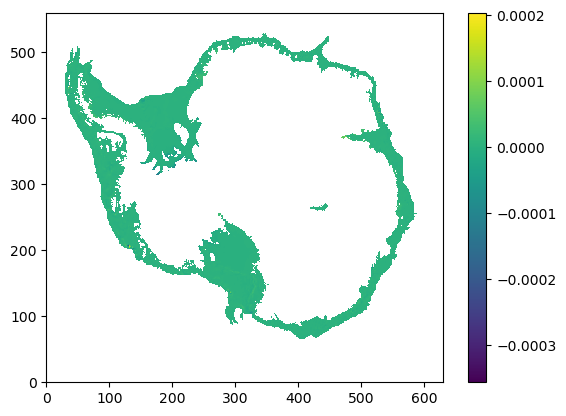

In [150]:
# define sum of all RHS:
RHS_budget = temp_hadv + temp_vadv + temp_hdiff + temp_vdiff
RHS_budget_masked = ma.masked_where(combined_condition, RHS_budget.sum('s_rho').isel(ocean_time=0))

plt.pcolormesh(RHS_budget_masked)#, vmin=-1e-12, vmax=1e-12, cmap='coolwarm')
plt.colorbar()

In [103]:
%%time
# integral with all RHS terms (as suggested by Wilkin)
RHS_budget_int = np.empty((tlen))
RHS_budget_vol = np.empty(np.squeeze(RHS_budget[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    RHS_budget_dz = RHS_budget[mm,:]*dz[mm,:]
    RHS_budget_vint = np.nansum(RHS_budget_dz, axis=0)
    RHS_budget_vint_masked =  ma.masked_where(combined_condition, RHS_budget_vint)
    RHS_budget_vol[mm,:] = RHS_budget_vint_masked*area
    RHS_budget_int[mm] = np.nansum(np.nansum(RHS_budget_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 39.2 s, sys: 26.6 s, total: 1min 5s
Wall time: 1min


In [104]:
%%time
# 3. heat tendency due to horizontal diffusion:
temp_hdiff_int = np.empty((tlen))
temp_hdiff_vol = np.empty(np.squeeze(temp_hdiff[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_hdiff_dz = temp_hdiff[mm,:]*dz[mm,:]
    temp_hdiff_vint = np.nansum(temp_hdiff_dz, axis=0)
    temp_hdiff_vint_masked =  ma.masked_where(combined_condition, temp_hdiff_vint)
    temp_hdiff_vol[mm,:] = temp_hdiff_vint_masked*area
    temp_hdiff_int[mm] = np.nansum(np.nansum(temp_hdiff_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 41.3 s, sys: 23.3 s, total: 1min 4s
Wall time: 52.5 s


In [105]:
%%time
# 4. heat tendency due to horizontal advection:
temp_hadv_int = np.empty((tlen))
temp_hadv_vol = np.empty(np.squeeze(temp_hadv[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_hadv_dz = temp_hadv[mm,:]*dz[mm,:]
    temp_hadv_vint = np.nansum(temp_hadv_dz, axis=0)
    temp_hadv_vint_masked =  ma.masked_where(combined_condition, temp_hadv_vint)
    temp_hadv_vol[mm,:] = temp_hadv_vint_masked*area
    temp_hadv_int[mm] = np.nansum(np.nansum(temp_hadv_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 36.6 s, sys: 20.3 s, total: 56.9 s
Wall time: 46.2 s


In [106]:
%%time
# 5. heat tendency due to vertical advection:
temp_vadv_int = np.empty((tlen))
temp_vadv_vol = np.empty(np.squeeze(temp_vadv[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_vadv_dz = temp_vadv[mm,:]*dz[mm,:]
    temp_vadv_vint = np.nansum(temp_vadv_dz, axis=0)
    temp_vadv_vint_masked =  ma.masked_where(combined_condition, temp_vadv_vint)
    temp_vadv_vol[mm,:] = temp_vadv_vint_masked*area
    temp_vadv_int[mm] = np.nansum(np.nansum(temp_vadv_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 40.4 s, sys: 27.7 s, total: 1min 8s
Wall time: 54.9 s


In [107]:
%%time
# 6. heat tendency due to vertical diffusion (should be equal to the sfc heat flux)
temp_vdiff_int = np.empty((tlen))
temp_vdiff_vol = np.empty(np.squeeze(temp_vdiff[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_vdiff_dz = temp_vdiff[mm,:]*dz[mm,:]
    temp_vdiff_vint = np.nansum(temp_vdiff_dz, axis=0)
    temp_vdiff_vint_masked =  ma.masked_where(combined_condition, temp_vdiff_vint) # I think I can remove the first masking, no need to repeat it.
    temp_vdiff_vol[mm,:] = temp_vdiff_vint_masked*area
    temp_vdiff_int[mm] = np.nansum(np.nansum(temp_vdiff_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 38.8 s, sys: 23.6 s, total: 1min 2s
Wall time: 50.4 s


In [108]:
%%time
# 7. heat tendency due to rotated diffusion (should be equal to the sfc heat flux)
temp_sdiff_int = np.empty((tlen))
temp_sdiff_vol = np.empty(np.squeeze(temp_sdiff[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_sdiff_dz = temp_sdiff[mm,:]*dz[mm,:]
    temp_sdiff_vint = np.nansum(temp_sdiff_dz, axis=0)
    temp_sdiff_vint_masked =  ma.masked_where(combined_condition, temp_sdiff_vint) # I think I can remove the first masking, no need to repeat it.
    temp_sdiff_vol[mm,:] = temp_sdiff_vint_masked*area
    temp_sdiff_int[mm] = np.nansum(np.nansum(temp_sdiff_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 37.1 s, sys: 21.9 s, total: 59 s
Wall time: 47.9 s


In [109]:
temp_hdiff_vol.shape

(365, 560, 630)

In [110]:
# calculate horizontal-integrated area:
area_masked = ma.masked_where(contour_masked_above == -1000, area)
area_sum = np.nansum(np.nansum(area_masked,axis=1), axis=0)

print(area_sum*1e-15)

0.017003058867057424


In [111]:
### JUST DOUBLE CHECK todays earlier/late afternoon calculatin with v3 contour_mask_above

# calculate horizontal-integrated area:
area_masked = ma.masked_where(contour_masked_above == -1000, area)
area_sum = np.nansum(np.nansum(area_masked,axis=1), axis=0)

print(area_sum*1e-15)

0.017003058867057424


In [112]:
print(temp_Rate.shape, dz.shape)

(365, 31, 560, 630) (365, 31, 560, 630)


In [113]:
print(shflux_area.shape, shflux_int.shape)
print(np.mean(shflux_int))#/area_sum)

(560, 630) (365,)
-67638951241634.61


In [114]:
print(temp_rate_vol.shape, temp_rate_int.shape)
print(np.mean(temp_rate_int))#/area_sum)

(365, 560, 630) (365,)
1136006435357.245


In [145]:
temp_rate_vol.shape

(365, 560, 630)

Text(0.5, 1.0, 'vert adv')

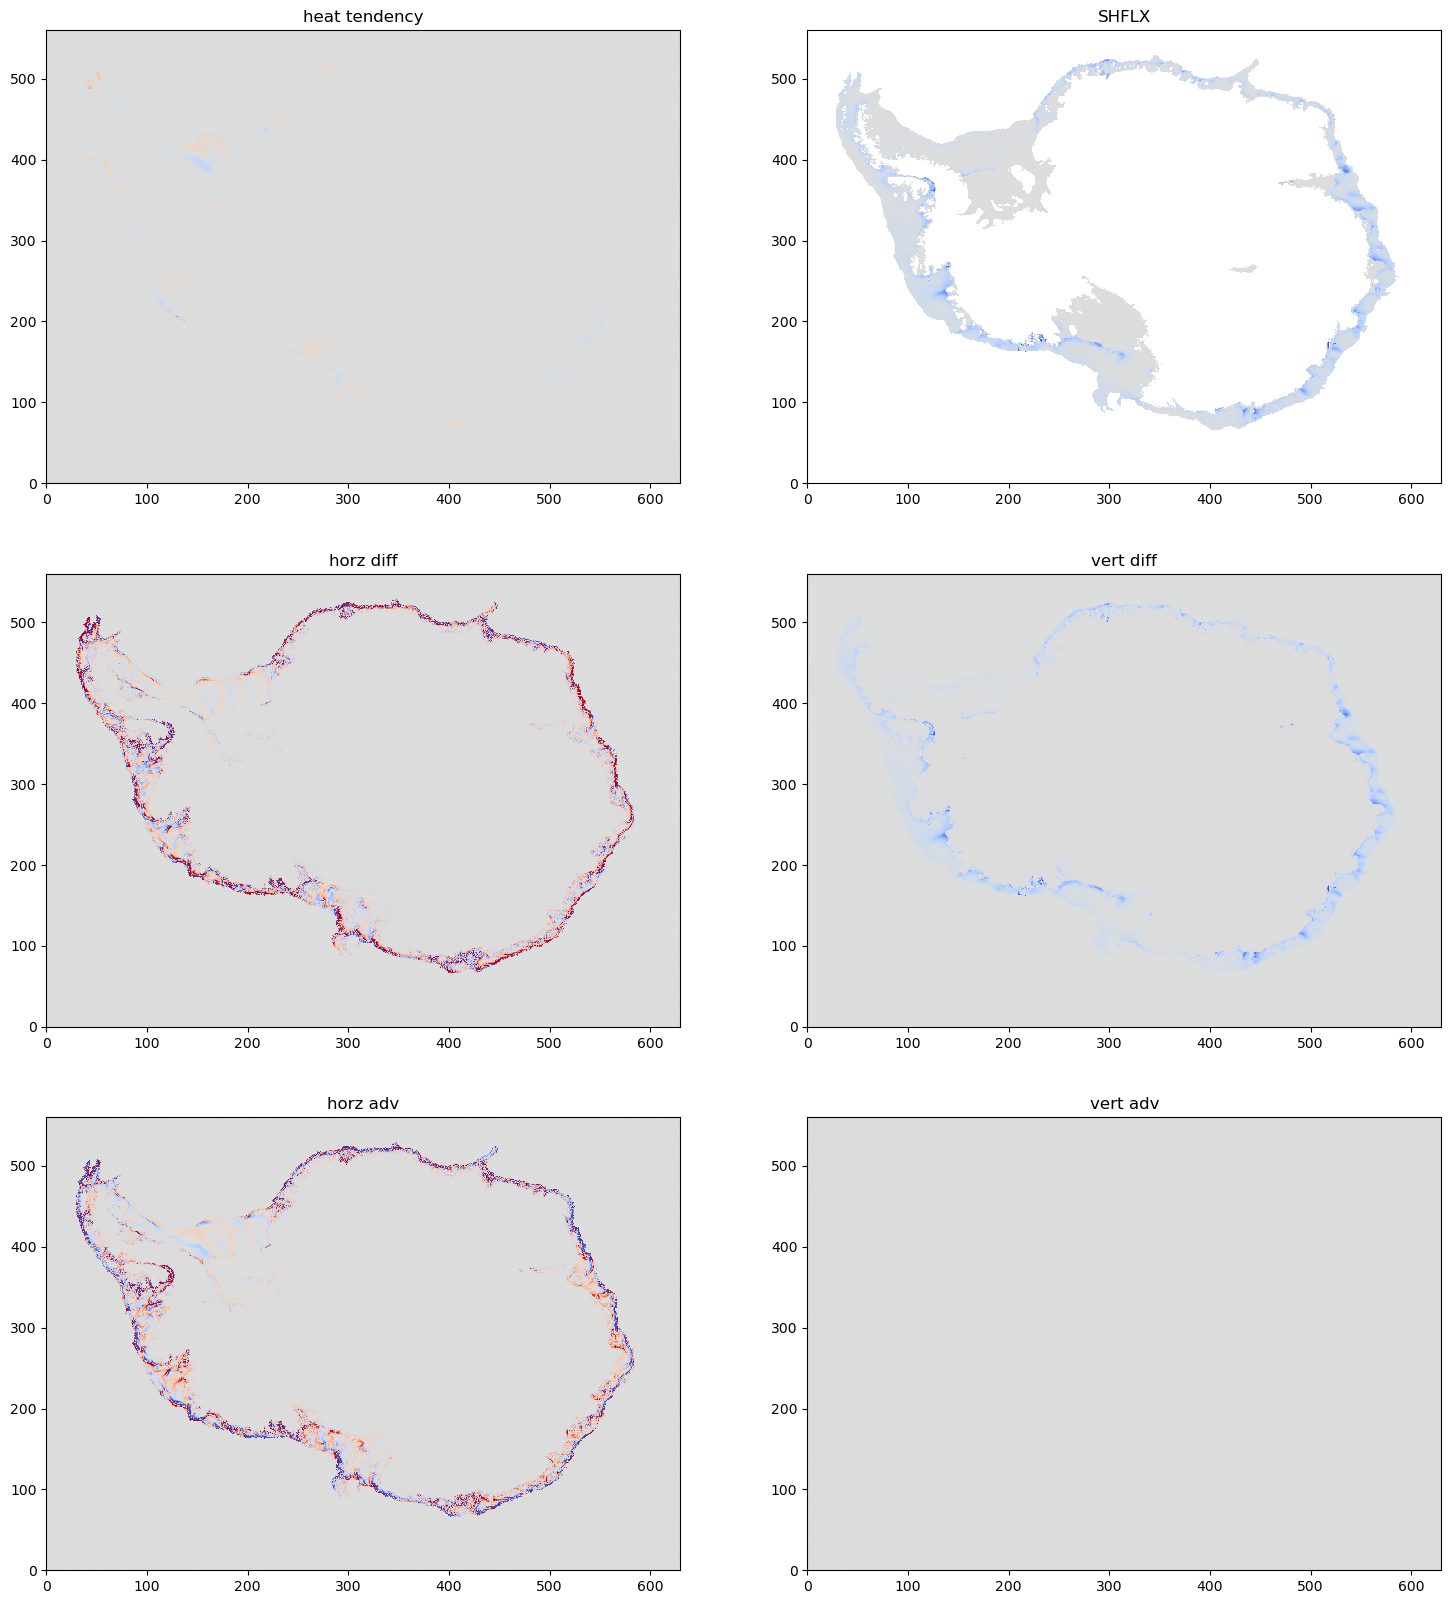

In [151]:
mm=35

# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
fig = plt.figure(figsize=(18,20))

ax1 = fig.add_subplot(321)
aa=ax1.pcolormesh(np.nanmean(temp_rate_vol, axis=0), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax1.set_title('heat tendency')

ax2 = fig.add_subplot(322)
ax2.pcolormesh(ma.masked_where(contour_masked_above == -1000, np.nanmean(shflux,axis=0)*(area/(Cp*rho0))), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax2.set_title('SHFLX')

ax3 = fig.add_subplot(323)
ax3.pcolormesh(np.nanmean(temp_hdiff_vol,axis=0), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax3.set_title('horz diff')

ax4 = fig.add_subplot(324)
ax4.pcolormesh(np.nanmean(temp_vdiff_vol,axis=0), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax4.set_title('vert diff')

ax5 = fig.add_subplot(325)
ax5.pcolormesh(np.nanmean(temp_hadv_vol,axis=0), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax5.set_title('horz adv')

ax6 = fig.add_subplot(326)
ax6.pcolormesh(np.nanmean(temp_vadv_vol,axis=0), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax6.set_title('vert adv')




In [124]:
# OHB integrated
print('OHC tendency annual avg (TW): ',np.nanmean(temp_rate_int)*1e-12)
# print(np.mean(temp_rate2_int)*1e-15)
print('Net sfc heat flux annual avg (TW): ',np.nanmean(shflux_int)*1e-12)
print('Residue (OHC - shflux) (TW): ',(np.nanmean(temp_rate_int)-np.nanmean(shflux_int))*1e-12)
print('Horz. diffusion (TW): ',np.nanmean(temp_hdiff_int)*1e-12)
print('Vert. diffusion (TW): ',np.nanmean(temp_vdiff_int)*1e-12)
print('Isop. diffusion (TW): ',np.nanmean(temp_sdiff_int)*1e-12)
print('Horz. advection (TW): ',np.nanmean(temp_hadv_int)*1e-12)
print('Vert. advection (TW): ',np.nanmean(temp_vadv_int)*1e-12)
print('Sum all above terms: ',np.nanmean(temp_hadv_int + temp_vadv_int + temp_hdiff_int + temp_vdiff_int)*1e-12)
print('Sum all RHS terms: ',np.nanmean(RHS_budget_int)*1e-12)

OHC tendency annual avg (TW):  1.136006435357245
Net sfc heat flux annual avg (TW):  -67.63895124163462
Residue (OHC - shflux) (TW):  68.77495767699185
Horz. diffusion (TW):  51.79160023931157
Vert. diffusion (TW):  -68.28727768784402
Isop. diffusion (TW):  -8.779801809301198e-10
Horz. advection (TW):  17.62343653550491
Vert. advection (TW):  -2.7245011860574814e-09
Sum all above terms:  1.1277590842479466
Sum all RHS terms:  1.1277590693782795


In [126]:
# OHB integrated, sum over 1year:
print('OHC tendency annual avg (TW): ',np.nansum(temp_rate_int)*1e-12)
# print(np.mean(temp_rate2_int)*1e-15)
print('Net sfc heat flux annual avg (TW): ',np.nansum(shflux_int)*1e-12)
print('Horz. diffusion (TW): ',np.nansum(temp_hdiff_int)*1e-12)
print('Vert. diffusion (TW): ',np.nansum(temp_vdiff_int)*1e-12)
print('Isop. diffusion (TW): ',np.nansum(temp_sdiff_int)*1e-12)
print('Horz. advection (TW): ',np.nansum(temp_hadv_int)*1e-12)
print('Vert. advection (TW): ',np.nansum(temp_vadv_int)*1e-12)
print('Sum all above terms: ',np.nansum(temp_hadv_int + temp_vadv_int + temp_hdiff_int + temp_vdiff_int)*1e-12)
print('Sum all RHS terms: ',np.nansum(RHS_budget_int)*1e-12)

OHC tendency annual avg (TW):  414.6423489053945
Net sfc heat flux annual avg (TW):  -24688.217203196633
Horz. diffusion (TW):  18903.934087348724
Vert. diffusion (TW):  -24924.856356063072
Isop. diffusion (TW):  -3.2046276603949373e-07
Horz. advection (TW):  6432.554335459292
Vert. advection (TW):  -9.944429329109806e-07
Sum all above terms:  411.6320657505005
Sum all RHS terms:  411.632060323072


In [127]:
print('Vert. advection (TW): ',np.nansum(temp_vadv_int)*1e-12)
print('Sum all above terms (incl. vert. adv): ',np.sum(temp_rate_int + shflux_int + temp_hdiff_int + temp_hadv_int)*1e-12)


Vert. advection (TW):  -9.944429329109806e-07
Sum all above terms (incl. vert. adv):  1062.913568516771


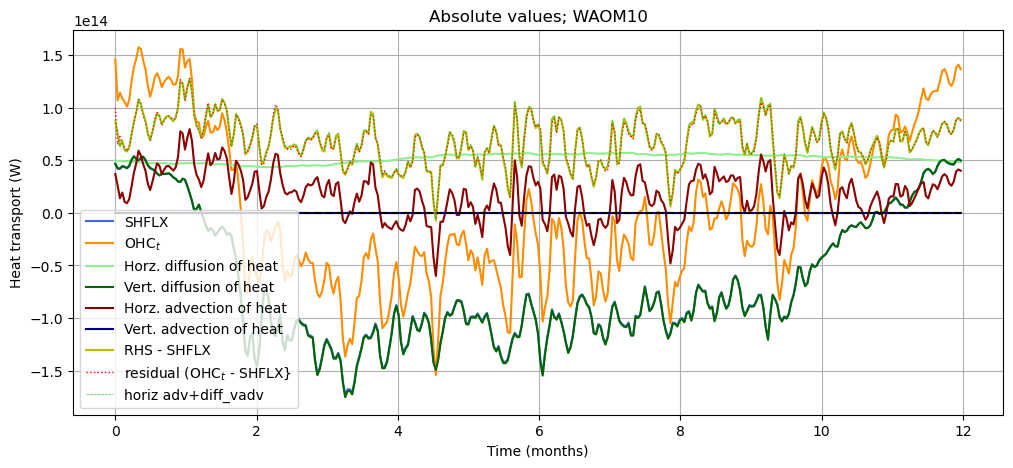

In [128]:
##### months=np.arange(0,365)*(1/30.41667)
all_rhs = temp_hdiff_int + temp_vdiff_int + temp_hadv_int + temp_vadv_int

fig, ax = plt.subplots(figsize = (12, 5))
plt.plot(months,np.divide(shflux_int,1), label='SHFLX', color='royalblue')
plt.plot(months,np.divide(temp_rate_int,1), label='OHC$_{t}$', color='darkorange')
plt.plot(months,temp_hdiff_int, label='Horz. diffusion of heat', color='lightgreen')
plt.plot(months,temp_vdiff_int, label='Vert. diffusion of heat', color='darkgreen')
plt.plot(months,temp_hadv_int, label='Horz. advection of heat',color='darkred')
plt.plot(months,temp_vadv_int, label='Vert. advection of heat',color='darkblue')
plt.plot(months,RHS_budget_int - shflux_int, label='RHS - SHFLX',color='y')

plt.plot(months,shflux_int*0,'--k')
plt.plot(months,temp_rate_int - shflux_int, ':r', label='residual (OHC$_{t}$ - SHFLX}',linewidth=1, color='red')
plt.plot(months,temp_hadv_int + temp_hdiff_int + temp_vadv_int, '--r', label='horiz adv+diff_vadv',linewidth=0.5, color='limegreen')
# plt.plot(months,all_rhs, '--m', label='all RHS',linewidth=1)
# plt.ylim([-2e14,2e14])
# print annual avg values:
# plt.text(10.2,-.5e14,str(np.round(np.mean(shflux_int)*1e-12,decimals=4)) + 'TW', color='royalblue')
# plt.text(10.2,1.65e14,str(np.round(np.mean(temp_rate_int)*1e-12,decimals=4)) + 'TW', color='darkorange')
# plt.text(9.2,1.1e14,str(np.round(np.mean(temp_rate_int - shflux_int)*1e-12,decimals=4)) + 'TW', color='red')
# # plt.text(10.2,1.35e14,str(np.round(np.mean(temp_hdiff_int)*1e-12,decimals=4)) + 'TW', color='green')
# plt.text(10.9,-.35e14,str(np.round(np.mean(temp_hadv_int)*1e-12,decimals=4)) + 'TW', color='darkred')
# plt.text(9,.8e14,str(np.round(np.mean(temp_vadv_int)*1e-12,decimals=4)) + 'TW', color='darkblue')

plt.grid()
plt.legend(loc='lower left')
plt.ylabel('Heat transport (W)')
plt.xlabel('Time (months)')
plt.title('Absolute values; WAOM10')


name_fig='WAOM10_OHB_south1500m_vint_annual_daily.png'
plt.savefig(fig_path + name_fig, dpi=300)

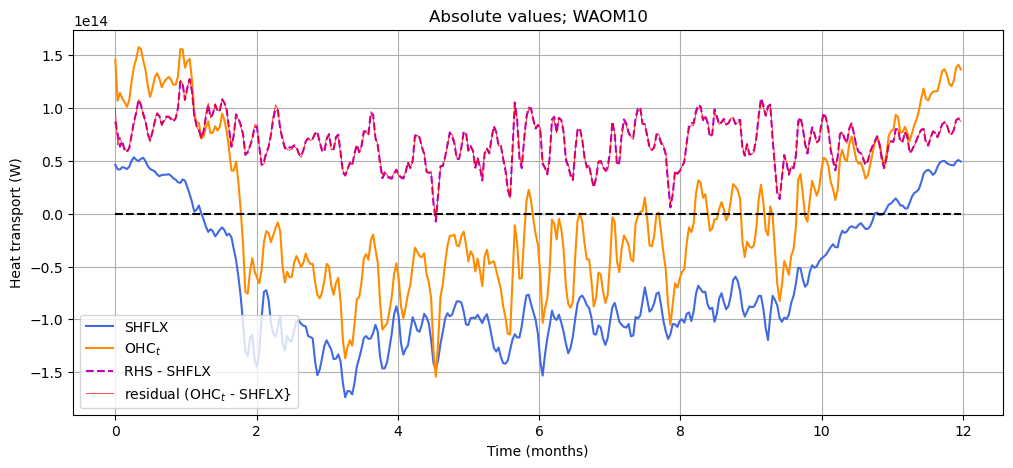

In [129]:
##### months=np.arange(0,365)*(1/30.41667)
all_rhs = temp_hdiff_int + temp_vdiff_int + temp_hadv_int + temp_vadv_int

fig, ax = plt.subplots(figsize = (12, 5))
plt.plot(months,np.divide(shflux_int,1), label='SHFLX', color='royalblue')
plt.plot(months,np.divide(temp_rate_int,1), label='OHC$_{t}$', color='darkorange')
plt.plot(months,RHS_budget_int - shflux_int,'--m', label='RHS - SHFLX')
plt.plot(months,temp_rate_int - shflux_int, '-r', label='residual (OHC$_{t}$ - SHFLX}',linewidth=0.5, color='red')

plt.plot(months,shflux_int*0,'--k')

plt.grid()
plt.legend(loc='lower left')
plt.ylabel('Heat transport (W)')
plt.xlabel('Time (months)')
plt.title('Absolute values; WAOM10')


name_fig='WAOM10_OHB-closure_test_south1500m_vint_annual_daily.png'
plt.savefig(fig_path + name_fig, dpi=300)

In [130]:
%%time

# temp_rate_int, shflux_int

months=np.arange(0,365)*(1/30.41667)

# save to netcdf file:
coordinatesC=dict(ocean_time=months)

temp_rate_int_xr = xr.DataArray(temp_rate_int, coords = coordinatesC, dims = ['ocean_time'])
shflux_int_xr = xr.DataArray(shflux_int, coords = coordinatesC, dims = ['ocean_time'])
temp_hdiff_int_xr = xr.DataArray(temp_hdiff_int, coords = coordinatesC, dims = ['ocean_time'])
temp_vdiff_int_xr = xr.DataArray(temp_vdiff_int, coords = coordinatesC, dims = ['ocean_time'])
temp_hadv_int_xr = xr.DataArray(temp_hadv_int, coords = coordinatesC, dims = ['ocean_time'])
temp_vadv_int_xr = xr.DataArray(temp_vadv_int, coords = coordinatesC, dims = ['ocean_time'])

files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
temp_rate_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_temp_rate_vint_daily', mode='w', format="NETCDF4")
shflux_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_shflux_vint_daily', mode='w', format="NETCDF4")
temp_hdiff_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_temp_hdiff_vint_daily', mode='w', format="NETCDF4")
temp_vdiff_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_temp_vdiff_vint_daily', mode='w', format="NETCDF4")
temp_hadv_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_temp_hadv_vint_daily', mode='w', format="NETCDF4")
temp_vadv_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_temp_vadv_vint_daily', mode='w', format="NETCDF4")

CPU times: user 476 ms, sys: 375 ms, total: 851 ms
Wall time: 23.2 s


In [131]:
shflux_int.shape

(365,)

In [132]:
print(np.nanmean(temp_rate_int - shflux_int)*1e-12)
print(np.nanmean(RHS_budget_int)*1e-12)

68.77495767699186
1.1277590693782795
